# Ex-Situ Training of a Binary Neural Network with STE for CMOS Crossbar Implementation

In [75]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os

In [18]:
def plot_loss_and_accuracy(loss_history, accuracy_history, num_epochs, element):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(range(1, num_epochs + 1), loss_history, label="Loss", color="blue")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(range(1, num_epochs + 1), accuracy_history, label="Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    plt.title("Loss and Accuracy vs. Epochs for "+ element)
    fig.tight_layout()
    plt.grid(True)
    plt.show()

## Data-set Preparation

In [3]:
A_true = np.array([
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[0,1,0,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,0,1,0], [0,1,0,1], [0,1,1,1], [0,1,0,1]],
    [[1,1,1,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,1,1,1], [0,1,0,1], [0,1,1,1], [0,1,0,1]]])

T_true = np.array([
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [1,1,1,0], [0,1,0,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,1,1], [0,0,1,0], [0,0,1,0]]])

V_true = np.array([
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [1,1,1,1]],
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[1,0,1,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[0,0,0,0], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[0,0,0,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,0,1,0], [0,0,0,0]],
    [[1,0,0,1], [1,0,0,1], [0,1,1,0], [0,0,0,0]]])

X_true = np.array([
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,0,0,0]],
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,1]],
    [[1,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,1], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [1,0,0,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,1,0,1]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]]])

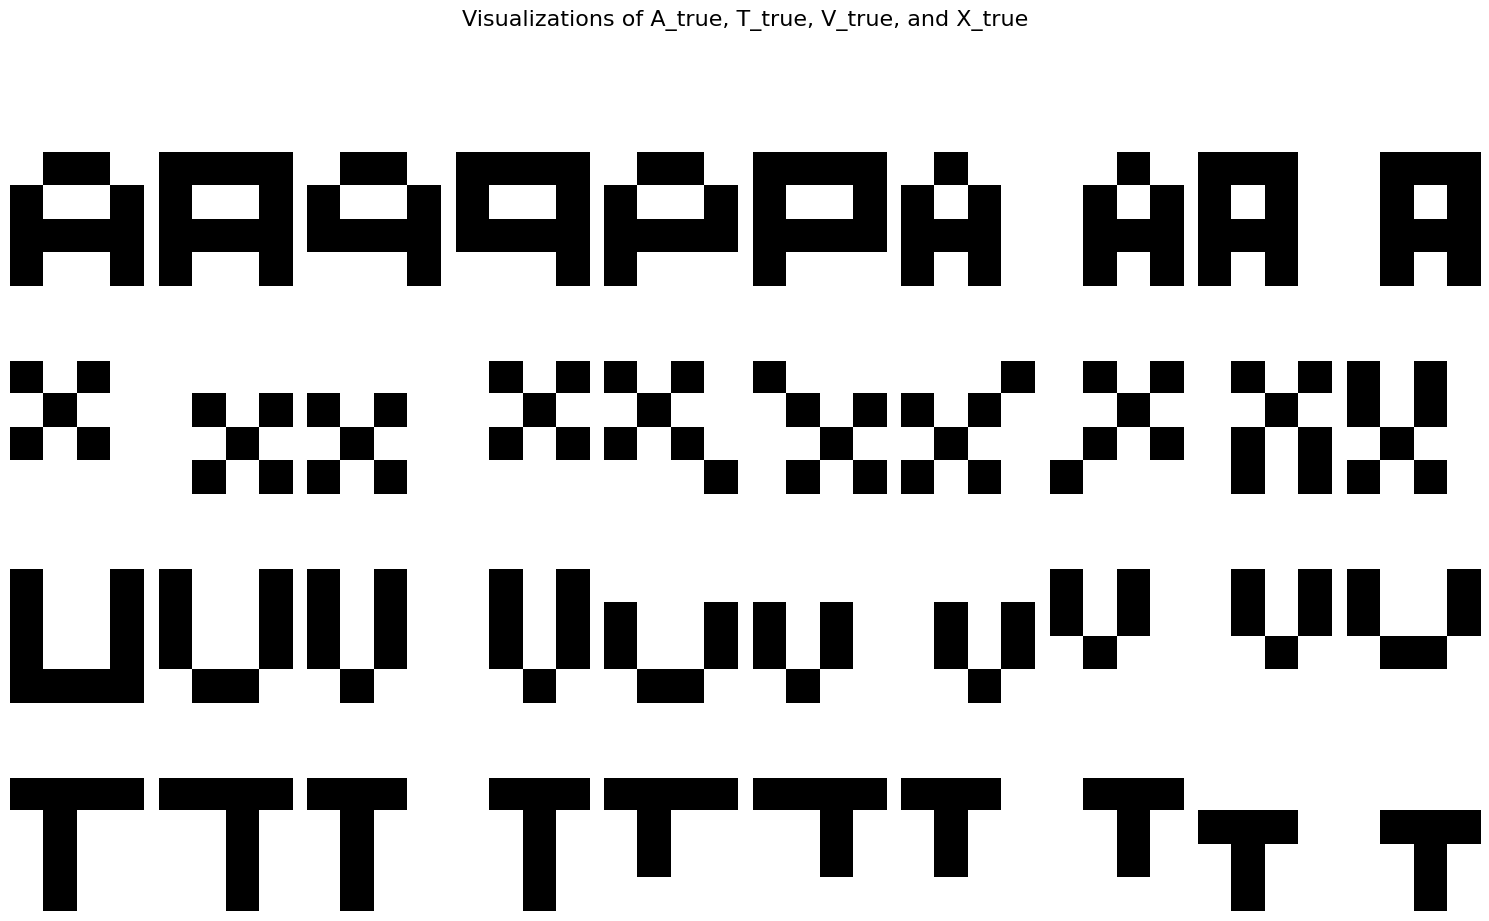

In [4]:
total_subplots = 4 * len(A_true)
fig, axes = plt.subplots(4, len(A_true), figsize=(15, 10))
fig.suptitle("Visualizations of A_true, T_true, V_true, and X_true", fontsize=16)

data_arrays = {"A": A_true, "X": X_true, "V": V_true, "T": T_true}

for row, (name, array) in enumerate(data_arrays.items()):
    for col in range(array.shape[0]):
        ax = axes[row, col]
        ax.imshow(1 - array[col], cmap="gray")
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(name, fontsize=12)
        if row == len(data_arrays) - 1:
            ax.set_xlabel(f"Slice {col+1}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust space for the suptitle
plt.show()

### Testing Set

In [5]:
AUG = np.zeros((4,160,4,4), dtype = np.uint8)
array = [A_true, T_true, V_true, X_true]
for index, letter in enumerate(array):
  for sample in range(10):
    AUG[index][sample*16:(sample+1)*16] = letter[sample]
    for i in range(4):
      for j in range(4):
        AUG[index][sample*16+4*i + j][i][j] =  np.abs(AUG[index][sample*16+4*i+j][i][j] - 1)
A_AUG, T_AUG, V_AUG, X_AUG = AUG

### Training Set

In [6]:
A_true_tensor = torch.tensor(A_true, dtype=torch.float32)
X_true_tensor = torch.tensor(X_true, dtype=torch.float32)
V_true_tensor = torch.tensor(V_true, dtype=torch.float32)
T_true_tensor = torch.tensor(T_true, dtype=torch.float32)

inputs = torch.cat([A_true_tensor, X_true_tensor, V_true_tensor, T_true_tensor], dim=0)

num_samples_per_category = len(A_true)
labels = torch.cat([
    torch.full((num_samples_per_category,), 0, dtype=torch.long),
    torch.full((num_samples_per_category,), 1, dtype=torch.long),
    torch.full((num_samples_per_category,), 2, dtype=torch.long),
    torch.full((num_samples_per_category,), 3, dtype=torch.long),
])

perm = torch.randperm(inputs.size(0))
train_inputs = inputs[perm]
train_labels = labels[perm]

In [7]:
train_labels

tensor([3, 3, 2, 0, 1, 0, 1, 2, 1, 0, 3, 3, 0, 1, 3, 0, 2, 2, 0, 3, 1, 2, 0, 0,
        0, 3, 2, 3, 1, 0, 2, 1, 2, 2, 2, 1, 3, 3, 1, 1])

In [8]:
def tensor_stats(tensor, name="Tensor"):
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")

## Custom Neural Network

1. **RRAMs/FeFETs** have only ON and OFF states that can be reliably controlled. A Sigmoid Function can be used to approximate this Binary behaviour. Hence we apply a Sigmoid on all weights before using them in the Fully Connected Layer. **G_ON** and **G_OFF** are the limits of this Sigmoid, where we approximate all ON RRAMs/FeFETs to have a conductance of G_ON and similarly for G_OFF.
2. Every Crossbar must be followed by an **Opamp or an Inverter** that is connect in Negative Feedback so that the Current Mode signal is converted to a Voltage mode. This also serves as the activation function. This again is a Sigmoid/Tanh, where the slope at the centre is the Feedback Resistance of the Amplifier **R_INV** and the Rails are limited by **V_INV**.
3. The input voltages are given by **V_1** which corresponds to the reading voltage and **V_0** which corresponds to the OFF voltage (=0)

In [21]:
class BinaryNeuralNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV, R_INV2, V_1, V_0, sharpness, initial_factor, h_layer = 8, verbose = False):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.w1 = nn.Parameter(torch.empty(h_layer, 16))
        self.w2 = nn.Parameter(torch.empty(4, h_layer))
        nn.init.xavier_uniform_(self.w1)
        nn.init.xavier_uniform_(self.w2)

        self.G_ON = G_ON
        self.G_OFF = G_OFF
        self.V_INV = V_INV
        self.R_INV = R_INV
        self.R_INV2 = R_INV2
        self.V_1 = V_1
        self.V_0 = V_0

        self.sharpness = sharpness

        self.w1.data = initial_factor*self.w1
        self.w2.data = initial_factor*self.w2

        self.verbose = verbose
        
    def forward(self, x):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        x = (self.V_1 - self.V_0) * x.view(x.size(0), -1) + self.V_0

        # RRAM Soft Binarization
        g1 = ((self.G_ON - self.G_OFF) * torch.sigmoid(self.w1 * self.sharpness) + self.G_OFF).to(x.device)
        g2 = ((self.G_ON - self.G_OFF) * torch.sigmoid(self.w2 * self.sharpness) + self.G_OFF).to(x.device)
        
        if self.verbose:
            tensor_stats(self.w1, "\nLatent Weights FC1")
            tensor_stats(self.w2, "Latent Weights FC2")
            tensor_stats(g1, "\nSoft Binarized Weights FC1")
            tensor_stats(g2, "Soft Binarized FC2")
        
        # Action of the Crossbar 1 
        x = F.linear(x, g1)
        if self.verbose: tensor_stats(x, "\nCurrents after Crossbar 1")
        
        # Action of Inverting Amplifier
        x = -self.V_INV * torch.tanh(self.R_INV * x / self.V_INV)
        if self.verbose: tensor_stats(x, "Voltage after Inv Amp 1")
        
        # Action of Crossbar 2
        x = F.linear(x, g2)
        if self.verbose: tensor_stats(x, "\nCurrents after Crossbar 2")
        
        # Action of Inverting Amplifier
        x = -self.V_INV * torch.tanh(self.R_INV2 * x/ self.V_INV)
        if self.verbose: tensor_stats(x, "Voltage after Inv Amp 2")
                
        return x
        
    def backprop(self, lr):
        if self.verbose:
            tensor_stats(lr * self.w1.grad, "\nLatent Gradients FC1")
            tensor_stats(lr * self.w2.grad, "Latent Gradients FC2")
    
        with torch.no_grad():
            self.w1 -= lr * self.w1.grad
            self.w2 -= lr * self.w2.grad
    
        self.w1.grad.zero_()
        self.w2.grad.zero_()

## Demonstration for G_ON = 1uS and G_OFF = 1nS

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BinaryNeuralNetwork(
    G_ON = 1e-6,
    G_OFF = 1e-9,
    V_INV = 5,
    R_INV = 1e+6,
    R_INV2 = 1e+6,
    V_1 = 0.1, 
    V_0 = 0, 
    sharpness = 10,
    initial_factor = 0.5, 
    h_layer = 8,
    verbose = True
).to(device)

criterion = nn.CrossEntropyLoss()  

In [23]:
lr = 1
for epoch in range(500):
    model.train()
    train_inputs.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, train_labels)
    loss.backward()
    model.backprop(lr)
    
    _, predictions = torch.max(outputs, dim=1)
    accuracy = (predictions == labels).float().mean().item() * 100
    
    print(f"\nEpoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%\n")


Latent Weights FC1 - Mean Magnitude: 1.23e-01, Max: 2.46e-01, Min: -2.31e-01
Latent Weights FC2 - Mean Magnitude: 1.88e-01, Max: 3.48e-01, Min: -3.22e-01

Soft Binarized Weights FC1 - Mean Magnitude: 5.18e-07, Max: 9.21e-07, Min: 9.14e-08
Soft Binarized FC2 - Mean Magnitude: 5.46e-07, Max: 9.70e-07, Min: 3.96e-08

Currents after Crossbar 1 - Mean Magnitude: 3.60e-07, Max: 6.84e-07, Min: 9.31e-08
Voltage after Inv Amp 1 - Mean Magnitude: 3.59e-01, Max: -9.31e-02, Min: -6.80e-01

Currents after Crossbar 2 - Mean Magnitude: 1.59e-06, Max: -8.67e-07, Min: -2.92e-06
Voltage after Inv Amp 2 - Mean Magnitude: 1.53e+00, Max: 2.63e+00, Min: 8.58e-01

Latent Gradients FC1 - Mean Magnitude: 5.15e-03, Max: 2.72e-02, Min: -2.03e-02
Latent Gradients FC2 - Mean Magnitude: 2.36e-02, Max: 4.39e-02, Min: -1.08e-01

Epoch 1, Loss: 1.4113, Accuracy: 27.50%


Latent Weights FC1 - Mean Magnitude: 1.23e-01, Max: 2.46e-01, Min: -2.29e-01
Latent Weights FC2 - Mean Magnitude: 1.91e-01, Max: 3.44e-01, Min: -3.0

The above shown example backpropagates and achieves 57% accuracy. **R_INV and V_INV are critical for backpropagation**, because if this inverting amplifier is not strong enough, the gradients will diminish in the second layer's tanh()

### Data Augmentation

For training purposes, we can superimpose noise onto the letters. We will have some amount of noise in the circuit too. This will help in generalizing for analog noise in the hardware too

In [77]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, noise_std=0.1):
        self.images = images
        self.labels = labels
        self.noise_std = noise_std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        noisy_image = image + torch.randn_like(image) * self.noise_std
        return noisy_image, label

noise_std = 0.1 
augmented_dataset = AugmentedDataset(train_inputs, train_labels, noise_std=noise_std)
dataloader = DataLoader(augmented_dataset, batch_size=10, shuffle=True)

# Model for RRAM

G_ON and G_OFF for a FeFET of dimensions similar to that we used in Endsem was 7.7e-5 and 2.88e-6 respectively

In [78]:
model_RRAM = BinaryNeuralNetwork(
    G_ON = 7.7e-5,
    G_OFF = 2.88e-6,
    V_INV = 5,
    R_INV = 5e+3,
    R_INV2 = 5e+3,
    V_1 = 0.1, 
    V_0 = -0.1, 
    sharpness = 100,
    initial_factor = 0.25, 
    h_layer = 8,
    verbose = False
).to(device)

In [84]:
try:
    with open("RRAM.txt", 'r') as f: lowest_loss_RRAM = float(f.read())
except:
    lowest_loss_RRAM = float('inf')

In [85]:
lr = 1
num_epochs = 500
loss_history_RRAM = []
accuracy_history_RRAM = []

for epoch in range(num_epochs):
    if epoch == 0:
        lr /= 1024
    elif epoch <= 10:
        lr *= 2

    model_RRAM.train()

    epoch_loss = 0
    epoch_accuracy = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        epoch_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        epoch_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss /= total_samples
    epoch_accuracy = (epoch_accuracy / total_samples) * 100

    loss_history_RRAM.append(epoch_loss)
    accuracy_history_RRAM.append(epoch_accuracy)

    # Check and update the lowest loss
    if epoch_loss < lowest_loss_RRAM:
        lowest_loss_RRAM = epoch_loss
        with open("RRAM.txt", "w") as f: f.write(f"{lowest_loss_RRAM:.6f}")
        model_filename = f"RRAM_{lowest_loss_RRAM:.2f}.pth"
        torch.save(model_RRAM.state_dict(), model_filename)
        print(f"Model saved: {model_filename}")

    if epoch % (num_epochs // 10) == 0 or epoch <= 10:
        print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    if epoch == (2 * num_epochs // 3):
        lr /= 2

Model saved: RRAM_1.36.pth
Epoch 1, LR: 0.0010, Loss: 1.3606, Accuracy: 47.50%
Model saved: RRAM_1.36.pth
Epoch 2, LR: 0.0020, Loss: 1.3598, Accuracy: 47.50%
Model saved: RRAM_1.36.pth
Epoch 3, LR: 0.0039, Loss: 1.3588, Accuracy: 47.50%
Model saved: RRAM_1.35.pth
Epoch 4, LR: 0.0078, Loss: 1.3549, Accuracy: 50.00%
Model saved: RRAM_1.35.pth
Epoch 5, LR: 0.0156, Loss: 1.3491, Accuracy: 60.00%
Model saved: RRAM_1.34.pth
Epoch 6, LR: 0.0312, Loss: 1.3407, Accuracy: 60.00%
Model saved: RRAM_1.34.pth
Epoch 7, LR: 0.0625, Loss: 1.3387, Accuracy: 52.50%
Model saved: RRAM_1.34.pth
Epoch 8, LR: 0.1250, Loss: 1.3369, Accuracy: 57.50%
Model saved: RRAM_1.33.pth
Epoch 9, LR: 0.2500, Loss: 1.3346, Accuracy: 60.00%
Model saved: RRAM_1.33.pth
Epoch 10, LR: 0.5000, Loss: 1.3317, Accuracy: 60.00%
Model saved: RRAM_1.33.pth
Epoch 11, LR: 1.0000, Loss: 1.3269, Accuracy: 57.50%
Model saved: RRAM_1.32.pth
Model saved: RRAM_1.31.pth
Model saved: RRAM_1.31.pth
Model saved: RRAM_1.31.pth
Model saved: RRAM_1.3

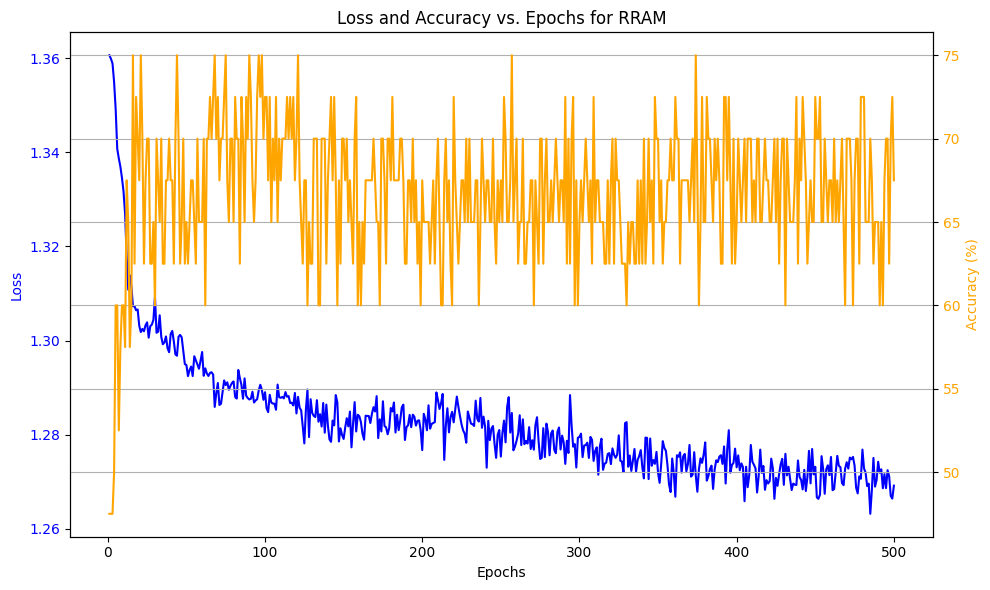

In [86]:
plot_loss_and_accuracy(loss_history_RRAM, accuracy_history_RRAM, num_epochs, "RRAM")

# Model for FeFET

G_ON and G_OFF for a FeFET of dimensions similar to that we used in Assignment 5 is __ and __ respectively

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BinaryNeuralNetwork(
    G_ON = 1e-6,
    G_OFF = 1e-9,
    V_INV = 5,
    R_INV = 1e+6,
    R_INV2 = 1e+6,
    V_1 = 0.1, 
    V_0 = 0, 
    sharpness = 10,
    initial_factor = 0.5, 
    h_layer = 8
).to(device)

criterion = nn.CrossEntropyLoss()  

In [ ]:
lr = 1
for epoch in range(500):
    model.train()
    inputs.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    model.backprop(lr)
    
    _, predictions = torch.max(outputs, dim=1)
    accuracy = (predictions == labels).float().mean().item() * 100
    
    print(f"\nEpoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%\n")